In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import tensorflow as tf

# Matplotlib might complain that a lot of figures are open, but suppress that warning.
plt.rcParams.update({'figure.max_open_warning': 0})

In [7]:
#read CSV file
data = pd.read_csv('fer2013.csv')

In [8]:
#defining Global variables
value_count=data.Usage.value_counts()
print(value_count)
train_count= value_count[0]
test_count=value_count[2]
validation_count=value_count[1]
width, height= 48, 48
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


In [9]:
#pre-processing data
#Convert data to train,validation and test 
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
#The following function make X and y for different data categories
def convert_data(data):
    data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])#Extract pixels from pixel column
    #conver each 48*48 image into a matrix of (48,48,1) to fed into netwotk
    data_X = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, width, height, 1)/255.0
    data_y=tf.keras.utils.to_categorical(data['emotion'], num_classes=7)
    #for em in data['emotion']:
    #    data_y.append(int(em))
    return data_X, data_y
X_trn, y_trn=convert_data(data_train)
X_val, y_val=convert_data(data_val)
X_tst, y_tst=convert_data(data_test)

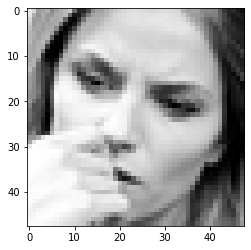

In [10]:
def rawtoImage(img):
    img=img.reshape(48,48)
    image= np.empty((48, 48, 3))
    image[:,:,0]=img
    image[:,:,1]=img
    image[:,:,2]=img
    return image
plt.imshow(rawtoImage(X_trn[2]))

In [11]:
#preparing data for Decision Tree Classifier and Random Fores Classifier
def prepare_data(X, y, count):
    X_new=np.array(X).reshape(count,width*height)
    y_new=np.argmax(y, axis=1)
    return X_new, y_new
X_train, y_train=prepare_data(X_trn, y_trn, train_count)
X_valid, y_valid=prepare_data(X_val, y_val, validation_count)
X_test, y_test=prepare_data(X_tst, y_tst, test_count)

In [12]:
DTC = sklearn.tree.DecisionTreeClassifier(splitter='random', random_state=0, max_depth=100)
DTC.fit(X_train,y_train)

print("train:   ", DTC.score(X_train,y_train))
print("test:   ", DTC.score(X_test,y_test))
print("validate:   ", DTC.score(X_valid,y_valid))

train:    0.9985022118499425
test:    0.3131791585399833
validate:    0.30760657564781274


In [13]:
def train_estimators(base_estimator, X, y, param_name, param_vals):
    dtc_list=[]
    for i in param_vals:
        params = {
            param_name: i,
        }
        new_estimator = sklearn.base.clone(base_estimator)
        #prevent param setting from messing with already-appended estimators
        new_estimator.fit(X,y)
        dtc_list.append(new_estimator.set_params(**params))
        print("Training " + str(new_estimator))
    return dtc_list

In [14]:
%%time
trained = train_estimators(sklearn.tree.DecisionTreeClassifier(splitter='random', random_state=0), X_train, y_train, 'max_depth', [1, 5, 10, 20, 50, 100])

Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')
Wall time: 1min 40s


In [18]:
%%time
trainedRFC = train_estimators(sklearn.ensemble.RandomForestClassifier(random_state=0), X_train, y_train, 'max_depth', [1, 5, 10, 20, 50, 100])

Training RandomForestClassifier(max_depth=1, random_state=0)
Training RandomForestClassifier(max_depth=5, random_state=0)
Training RandomForestClassifier(max_depth=10, random_state=0)
Training RandomForestClassifier(max_depth=20, random_state=0)
Training RandomForestClassifier(max_depth=50, random_state=0)
Training RandomForestClassifier(max_depth=100, random_state=0)
Wall time: 9min 7s


In [15]:
def score_estimators(X_param, y_param, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    scorelist = []
    for e in estimators:
        e.fit(X_train,y_train)
        scorelist.append(e.score(X_param,y_param))
    return scorelist

In [16]:
def plot_estimator_scores(estimators, param_name, param_vals):
    trainlist = score_estimators(X_train, y_train, estimators)
    testlist = score_estimators(X_test, y_test, estimators)
    vallist = score_estimators(X_valid, y_valid, estimators)
    plt.plot(np.arange(6), trainlist, color='green', marker='.',ms=10.0,label='train')
    plt.plot(np.arange(6), testlist, color='black',ls='--',label='test')
    plt.plot(np.arange(6), vallist, color='red',marker='.',ms=10.0,label='validate')
    plt.legend()
    plt.title(str(estimators[0].__class__.__name__) + " score vs " + param_name)
    plt.xticks(np.arange(6),param_vals)
    print(trainlist)
    print(testlist)
    print(vallist)

[0.26284440419380684, 0.3058274408722004, 0.4454003970880212, 0.9615451600543383, 0.9985022118499425, 0.9985022118499425]
[0.2521593758707161, 0.2897743103928671, 0.3251602117581499, 0.3179158539983282, 0.3131791585399833, 0.3131791585399833]
[0.2672053496795765, 0.2911674561159097, 0.3148509334076344, 0.32014488715519646, 0.30760657564781274, 0.30760657564781274]
Wall time: 3min 58s


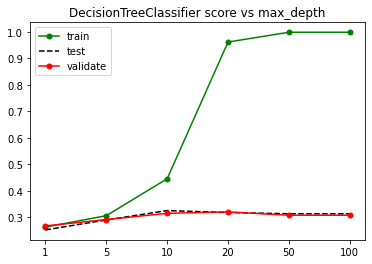

In [17]:
%%time
plot_estimator_scores(trained, 'max_depth', [1, 5, 10, 20, 50, 100])

[0.2513149186666202, 0.33557421017799294, 0.6957400118429761, 0.9985022118499425, 0.9985022118499425, 0.9985022118499425]
[0.2449150181108944, 0.3165227082752856, 0.4076344385622736, 0.4686542212315408, 0.4711618835330176, 0.47199777096684314]
[0.24937308442463083, 0.32265254945667315, 0.4076344385622736, 0.46447478406241294, 0.4575090554471998, 0.4566731680133742]
Wall time: 17min 25s


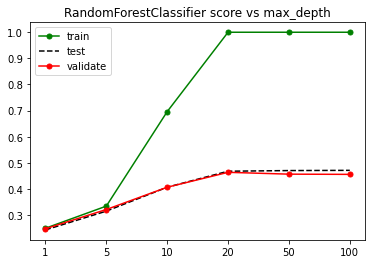

In [19]:
%%time
plot_estimator_scores(trainedRFC, 'max_depth', [1, 5, 10, 20, 50, 100])

In [90]:
batch_size=100 #Use 100 training samples at a time to compute the gradient.
num_epoch=10
next_epoch=1
num_classes=7

In [92]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [93]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=(48,48,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [94]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 24, 24, 128)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                  

In [95]:
model_train = model.fit(X_trn, y_trn, batch_size=batch_size,epochs=num_epoch,verbose=1,validation_data=(X_val, y_val))

Epoch 1/10
288/288 [==============================] - 480s 2s/step - loss: 1.6412 - accuracy: 0.3541 - val_loss: 1.4799 - val_accuracy: 0.4422
Epoch 2/10
288/288 [==============================] - 535s 2s/step - loss: 1.3732 - accuracy: 0.4745 - val_loss: 1.3502 - val_accuracy: 0.4781
Epoch 3/10
288/288 [==============================] - 572s 2s/step - loss: 1.2278 - accuracy: 0.5331 - val_loss: 1.2552 - val_accuracy: 0.5191
Epoch 4/10
288/288 [==============================] - 597s 2s/step - loss: 1.0799 - accuracy: 0.5966 - val_loss: 1.2551 - val_accuracy: 0.5269
Epoch 5/10
288/288 [==============================] - 602s 2s/step - loss: 0.9145 - accuracy: 0.6624 - val_loss: 1.2748 - val_accuracy: 0.5341
Epoch 6/10
288/288 [==============================] - 532s 2s/step - loss: 0.7205 - accuracy: 0.7416 - val_loss: 1.3612 - val_accuracy: 0.5464
Epoch 7/10
288/288 [==============================] - 502s 2s/step - loss: 0.5079 - accuracy: 0.8247 - val_loss: 1.5638 - val_accuracy: 0.5316

In [96]:
test_eval = model.evaluate(X_tst, y_tst, verbose=0)

In [149]:
print('Test loss:', round(test_eval[0],3))
print('Test accuracy:', round(test_eval[1],3))

Test loss: 2.233
Test accuracy: 0.54


In [128]:
test_predict=model.predict(X_tst, verbose=1)
predict_indexes = tf.argmax(test_predict, axis=1)
y_test_indexes=tf.argmax(y_tst, axis=1)

113/113 [==============================] - 19s 164ms/step


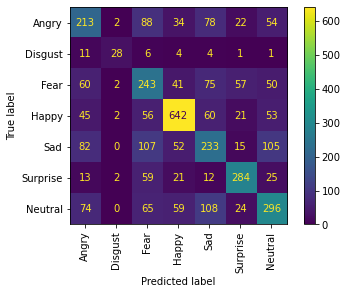

In [135]:
cm = sklearn.metrics.confusion_matrix(y_test_indexes, predict_indexes, labels=[0,1,2,3,4,5,6])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation=90);

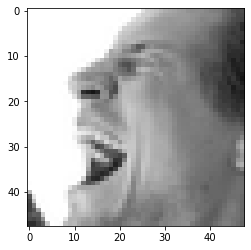

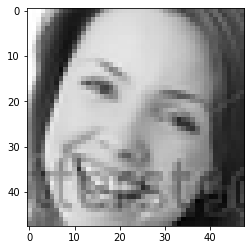

In [147]:
#All happy emotions that misclassified as disgust.
emotion_happy=np.where(y_test_indexes == 3)[0]
misclassified_index=[]
for em in emotion_happy:
    if predict_indexes[em]==1:
        misclassified_index.append(em)
for i in misclassified_index:
    plt.figure()
    plt.imshow(rawtoImage(X_tst[i]))

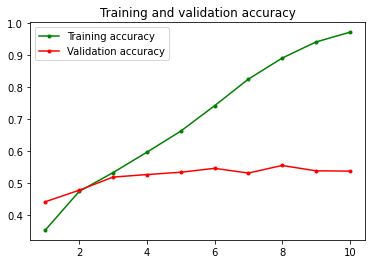

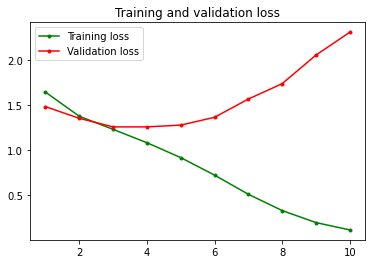

In [112]:
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = np.arange(1, 11, 1)
plt.plot(epochs, accuracy, color='green', marker='.', label='Training accuracy')
plt.plot(epochs, val_accuracy, color='red',marker='.', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, color='green', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='red',marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [42]:
np.random.seed(0)
param_grid={'criterion':['gini', 'entropy'], 'splitter':['best', 'random'],
            'max_depth':[1, 5, 10, 20, 50, 100],'max_features':['auto', 'sqrt', 'log2']}
decTree=sklearn.tree.DecisionTreeClassifier()
rscv=sklearn.model_selection.RandomizedSearchCV(decTree,param_grid,n_iter=20, cv=4)
search=rscv.fit(np.array(X_trn).reshape(28709,48*48), np.array(y_trn))

In [43]:
for param in search.best_params_:
    print('{}: {}'.format(param,search.best_params_[param]))

splitter: best
max_features: auto
max_depth: 100
criterion: gini


In [44]:
print('cross-validation score of best hyperparameters:             {}'.format(round(search.best_score_, 3)))
print('training score of model trained using best hyperparameters: {}'.format(round(search.score(np.array(X_trn).reshape(28709,48*48), y_trn), 3)))
print('testing score of model trained using best hyperparameters:  {}'.format(round(search.score(np.array(X_tst).reshape(3589,48*48), y_tst), 3)))

cross-validation score of best hyperparameters:             0.297
training score of model trained using best hyperparameters: 0.999
testing score of model trained using best hyperparameters:  0.318
